In [1]:
%cd src

/Users/kristjan.roosild/OneDrive/kool/AutoML/projekt/automl/src


In [2]:
import gzip
import json

trial_filenames = [
    'trials/xgboost_at_2021-12-29 14-50-42.json.gz',
    'trials/xgboost_at_2021-12-29 15-00-28.json.gz',
    'trials/lightgbm_at_2021-12-29 17-17-34.json.gz',
    'trials/lightgbm_at_2022-01-01 16-03-49.json.gz'
]

def get_best_loss(filename):
    best_loss = 1.0
    with gzip.open(filename) as fp:
        results = json.load(fp)
        for res in results:
            current_loss = res['result']['loss']
            if current_loss < best_loss:
                best_loss = current_loss
    return best_loss

best_losses = {}
for fn in trial_filenames:
    best_losses[fn]=get_best_loss(fn)


In [4]:
log_filenames = [
    'trials/slurm-25398853.out.gz',
    'trials/slurm-25398856.out.gz',
    'trials/slurm-25398910.out.gz',
    'trials/slurm-25398911.out.gz'
]

def contains_loss(loss, filename):
    with gzip.open(filename, mode='rt') as log:
        for line in log:
            if str(loss) in line:
                return True
        return False

def hp_range_type(filename):
    with gzip.open(filename, mode='rt') as log:
        for line in log:
            if '_temp.py' in line:
                return 'uniform'
        return 'choice'

def algo_name(filename):
    with gzip.open(filename, mode='rt') as log:
        for line in log:
            if 'LightGBM' in line:
                return 'LightGBM'
        return 'XGBoost'


def get_baseline_auc(filename):
    with gzip.open(filename, mode='rt') as log_containing_baseline:
        for line in log_containing_baseline:
            if 'AUC' in line:
                break
    return float(line.split(' = ')[1].strip())

for best_loss in best_losses.values():
    for fn in log_filenames:
        if contains_loss(best_loss, fn):
            print(f'Using {algo_name(fn)} the baseline AUC was {get_baseline_auc(fn):.6}. '
                  f'The best AUC achieved using hyperopt (using hp.{hp_range_type(fn)} mostly) was {1-best_loss:.6}')

Using XGBoost the baseline AUC was 0.838118. The best AUC achieved using hyperopt (using hp.choice mostly) was 0.896796
Using XGBoost the baseline AUC was 0.838118. The best AUC achieved using hyperopt (using hp.uniform mostly) was 0.897037
Using LightGBM the baseline AUC was 0.848149. The best AUC achieved using hyperopt (using hp.choice mostly) was 0.900598
Using LightGBM the baseline AUC was 0.848149. The best AUC achieved using hyperopt (using hp.uniform mostly) was 0.901172


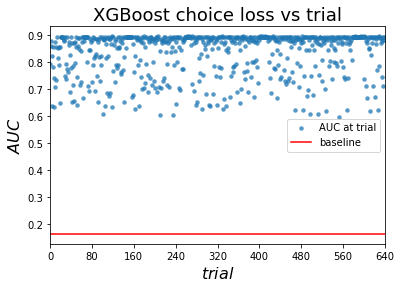

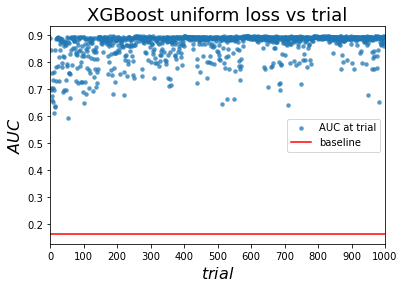

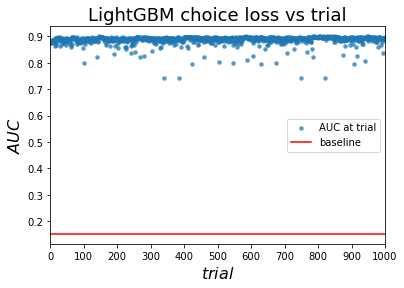

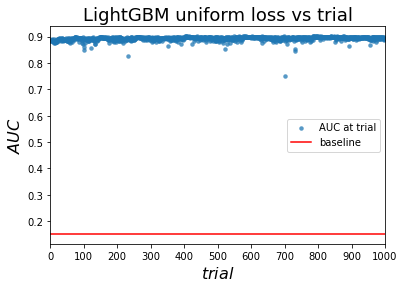

In [6]:
from monitor import Monitor

for jsonfn, best_loss in best_losses.items():
    for fn in log_filenames:
        if contains_loss(best_loss, fn):
            title = f'{algo_name(fn)} {hp_range_type(fn)} loss vs trial'
            monitor = Monitor(get_baseline_auc(fn), f'trials/{title}')
            with gzip.open(jsonfn) as fp:
                results = json.load(fp)
                monitor.save_trials_auc_graph(results, title)